# Visual Reasoning Baseline Model

1. Data preprocessing 어떻게 하면될까?
 - Image feature를 resnet으로 미리 추출해둘까? --> baseline돌리기 까다로움
 - DataLoader 구성을 어떻게하면 좋을까? --> DataSet class 안에서 feature를 return 할까? 아니면 ResNet을 밖에둘까


2. Baseline Model 설계를 어떻게?
 - Encoder: image encoding 어떻게 하면 될까? Answer Image 3개를 한꺼번에 encoding? 혹은 각각 encoding 한 후 Weight Sum??
 - Decoder: Answer 후보 중 정답후보를 어떻게 고를까? Similarity 기준? KL 같은 분포기준? Attention 기반 Scoring??


3. SOTA Model 설계를 어떻게? 

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

## 1. Import all packages

In [2]:
import pandas as pd
import numpy as np
import json
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision
import torch.optim as optim
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from PIL import Image
from PIL import Image, ImageDraw
import cv2

import matplotlib
import matplotlib.pyplot as plt
#import matplotlib.font_manager as fm
#fm.get_fontconfig_fonts()
#font_location = './NanumGothic.ttf'
#font_location = 'C:/Windows/Fonts/NanumGothic.ttf' # For Windows
#font_name = fm.FontProperties(fname=font_location).get_name()
#matplotlib.rc('font', family=font_name)

%matplotlib inline
# 브라우저에서 바로 이미지를 그린다.


In [3]:
!pwd

/home/ktlim/Visual_Reasoning/task1


## 2. Preparation of datasets

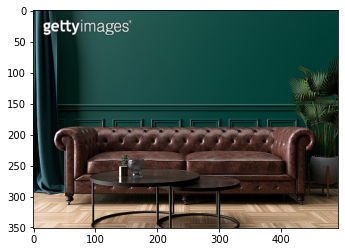

In [4]:
class Config:
    def __init__(self, args=None):
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.distributed = False
        self.gpu_id = "0,1"
        self.HOME_DIR = "./datasets/"
        self.TASK_NAME = "similarity3/"
        self.FOLDER_NAME = "002001/"
        self.IMAGE_LIST = [
                "394d38865dbe46598e3d59a9d4936982.jpg", 
                "50c35498b763434f9c3471489f9496bd.jpg", 
                "3c42c21d6abb43e7be8b1d0438c60857.jpg",
                "7fcab1ded999484993ea3c2213bcb30c.jpg",
                "2288119eaeae415694e8991f59bad8cc.jpg",
                "0179032cb2064a84a6b250ace5937ae4.jpg",
                "868128c167564437bb1cb262276354f3.jpg",
                "afc80c8a8bfc451d8b2f23310150056d.jpg",
                "f679f7e5153d4139b747e7a28cf3b2d6.jpg",
                "cd5b040a28a947cb9d8d6c28e12153bf.jpg",
                "2181b14e47b5460ba647ba82b82c780e.jpg",
                "d14e31e20b1847e9a63392c699e9a16d.jpg",
                "d7e9c6b4f4824cd0ae556e623aa509fc.jpg",
                 "cdf0d3fad2ca4c4eb4c3c3de42a44212.jpg",
                "9d5fdcd9aec949998b7526f2f892f2e8.jpg"
             ]
        self.JSON_NAME = "002001"+".json"
        self.input_dim = 512
        self.mlp_hidden = 1024
        self.n_epoch = 8


config = Config()
a_image_file = config.HOME_DIR+config.TASK_NAME+config.FOLDER_NAME+config.IMAGE_LIST[0]
a_image = plt.imread(a_image_file)
plt.imshow(a_image)

In [5]:
def get_data(config):
    
    home_dir = config.HOME_DIR
    task_name = config.TASK_NAME
    dir_list = os.listdir(home_dir+task_name)
    sample_list = []
    
    for directory in dir_list:
        FOLDER_NAME = directory+"/"
        JSON_NAME = directory+".json"
        FILE_PATH = home_dir+task_name+FOLDER_NAME
        a_data = json.load(open(FILE_PATH+JSON_NAME))
        a_data["file_path"] = FILE_PATH
        a_data["answer1"] = [a_data["Answers"][0]]
        a_data["answer2"] = [a_data["Answers"][1]]
        a_data["answer3"] = [a_data["Answers"][2]]
        del a_data["Answers"]
        sample_list.append(a_data)
        
    return sample_list

def get_img_argumentation():
    #이미지 전처리를 위한 이미지 크기 변환 및 각도조정을 위한 transform 선언

    transform = transforms.Compose(
        [
            transforms.Resize((384, 384)),
            transforms.RandomCrop((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    )
    
    return transform


In [6]:
"""
16x3072 and 2048x1024
16x3072 and 1024x1024)
삭제
033484/665733f2fe9445dd925acf879e7c37d6.jpg
032375/a67cab7955164016a2c809b21f0022e1.jpg
034442/2e3c2bea74c54526a9e84d7773d046e2.jpg
048793/d6d88f7427ee40aebd1037b91cbbbef5.jpg
029028/18053f5f4a4f4a8987d42dbd603a509d.jpg
048145/1df0b702d7e648ce92292b4e76b7f76c.jpg
"""

'\n16x3072 and 2048x1024\n16x3072 and 1024x1024)\n삭제\n033484/665733f2fe9445dd925acf879e7c37d6.jpg\n032375/a67cab7955164016a2c809b21f0022e1.jpg\n034442/2e3c2bea74c54526a9e84d7773d046e2.jpg\n048793/d6d88f7427ee40aebd1037b91cbbbef5.jpg\n029028/18053f5f4a4f4a8987d42dbd603a509d.jpg\n048145/1df0b702d7e648ce92292b4e76b7f76c.jpg\n'

In [7]:
class Similarity1_Dataset(torch.utils.data.Dataset):
    
    def __init__(self, df, config=None, transform=None):
        self.df = df
        self.config = config
        self.transform = transform
        
        
    def __len__(self):
        return len(self.df)
        
    def __getitem__(self, idx):
        sample = self.df.iloc[idx]
        
        target = sample["correct_answer_group_ID"][0]
        category = sample["category"]
        
        q1_img = [sample["file_path"] + qes_img["image_url"] for qes_img in sample["Questions"][0]["images"]]
        q2_img = [sample["file_path"] + qes_img["image_url"] for qes_img in sample["Questions"][1]["images"]]
        
        a1_img = [sample["file_path"] + ans_img["image_url"] for ans_img in sample["answer1"][0]["images"]]
        a2_img = [sample["file_path"] + ans_img["image_url"] for ans_img in sample["answer2"][0]["images"]]
        a3_img = [sample["file_path"] + ans_img["image_url"] for ans_img in sample["answer3"][0]["images"]]
        
        q1_img_feature = [self.transform(Image.open(img).convert('RGB')) for img in q1_img] #이미지 데이터를 RGB형태로 읽음 
        q2_img_feature = [self.transform(Image.open(img).convert('RGB')) for img in q2_img] #이미지 데이터의 크기 및 각도등을 변경
        
        
        a1_img_feature = [self.transform(Image.open(img).convert('RGB')) for img in a1_img]
        a2_img_feature = [self.transform(Image.open(img).convert('RGB')) for img in a2_img]
        a3_img_feature = [self.transform(Image.open(img).convert('RGB')) for img in a3_img]
        
        return {
            "target": target,
            "q1_imgs": q1_img_feature,
            "q2_imgs": q2_img_feature,
            "a1_imgs": a1_img_feature,
            "a2_imgs": a2_img_feature,
            "a3_imgs": a3_img_feature
        }
        
    

In [8]:
def make_sequential(in_channels, out_channels, *args, **kwargs):
    return nn.Sequential(nn.Conv2d(in_channels, out_channels, *args, **kwargs),
           nn.BatchNorm2d(out_channels),
           nn.ReLu(),
           nn.MaxPool2d(*args, **kwargs))

class VRSimilarity(nn.Module):
    def __init__(self, config):
        super(VRSimilarity, self).__init__()
        
        self.config = config
        self.backborne = torchvision.models.resnet50(pretrained=True)
        self.backborne.fc = nn.Linear(self.backborne.fc.in_features, self.config.input_dim)
        self.fc = nn.Sequential(
                    nn.Linear(3072, self.config.mlp_hidden),
                    nn.ReLU(),
                    nn.Dropout(0.2),
                    nn.Linear(self.config.mlp_hidden, 2),
        )

    def forward(self, samples):
        
        #Question Image Feature
        q1_img1 = self.backborne(samples["q1_imgs"][0])
        q1_img2 = self.backborne(samples["q1_imgs"][1])
        q1_img3 = self.backborne(samples["q1_imgs"][2])
        
        q2_img1 = self.backborne(samples["q2_imgs"][0])
        q2_img2 = self.backborne(samples["q2_imgs"][1])
        q2_img3 = self.backborne(samples["q2_imgs"][2])
        
        #Answer1 Image Feature
        a1_img1 = self.backborne(samples["a1_imgs"][0])
        a1_img2 = self.backborne(samples["a1_imgs"][1])
        a1_img3 = self.backborne(samples["a1_imgs"][2])
        
        #Answer2 Image Feature
        a2_img1 = self.backborne(samples["a2_imgs"][0])
        a2_img2 = self.backborne(samples["a2_imgs"][1])
        a2_img3 = self.backborne(samples["a2_imgs"][2])
        
        #Answer3 Image Feature
        a3_img1 = self.backborne(samples["a3_imgs"][0])
        a3_img2 = self.backborne(samples["a3_imgs"][1])
        a3_img3 = self.backborne(samples["a3_imgs"][2])
        
        q_a1 = torch.cat([q1_img1, q1_img2, q1_img3, a1_img1, a1_img2, a1_img3], axis=1)
        q_a2 = torch.cat([q2_img1, q2_img2, q2_img3, a2_img1, a2_img2, a2_img3], axis=1)
        q_a3 = torch.cat([q2_img1, q2_img2, q2_img3, a3_img1, a3_img2, a3_img3], axis=1)
        
        q_a1_logit = self.fc(q_a1)
        q_a2_logit = self.fc(q_a2)
        q_a3_logit = self.fc(q_a3)
        
        return {
            "q_a1_logit": F.log_softmax(q_a1_logit, dim=1),
            "q_a2_logit": F.log_softmax(q_a2_logit, dim=1),
            "q_a3_logit": F.log_softmax(q_a3_logit, dim=1)
        }


In [17]:
def train_fn(model, train_loader, optimizer, loss_fn, config):
    
    total_count_correct = 0
    total_num_example = 0
    total_loss = []
    
    model.train()
    device = config.device
    
    for batch in tqdm(train_loader):          
        # Question Image Feature
        #  batch["q_img"] = batch["q_img"].to(device)
        batch["q1_imgs"][0] = batch["q1_imgs"][0].to(device)
        batch["q1_imgs"][1] = batch["q1_imgs"][1].to(device)
        batch["q1_imgs"][2] = batch["q1_imgs"][2].to(device)
        
        batch["q2_imgs"][0] = batch["q2_imgs"][0].to(device)
        batch["q2_imgs"][1] = batch["q2_imgs"][1].to(device)
        batch["q2_imgs"][2] = batch["q2_imgs"][2].to(device)
        
        # Answer1 Image Feature
        batch["a1_imgs"][0] = batch["a1_imgs"][0].to(device)
        batch["a1_imgs"][1] = batch["a1_imgs"][1].to(device)
        batch["a1_imgs"][2] = batch["a1_imgs"][2].to(device)
        
        # Answer2 Image Feature
        batch["a2_imgs"][0] = batch["a2_imgs"][0].to(device)
        batch["a2_imgs"][1] = batch["a2_imgs"][1].to(device)
        batch["a2_imgs"][2] = batch["a2_imgs"][2].to(device)
        
        # Answer3 Image Feature
        batch["a3_imgs"][0] = batch["a3_imgs"][0].to(device)
        batch["a3_imgs"][1] = batch["a3_imgs"][1].to(device)
        batch["a3_imgs"][2] = batch["a3_imgs"][2].to(device)
    
        logits = model(batch)

        target_a1, target_a2, target_a3 = batch["target"].long().to(device), (batch["target"] == 0).type(torch.long).to(device), (batch["target"] == 0).type(torch.long).to(device)
        #print(logits["q_a1_logit"], logits["q_a1_logit"].size())
#         print(target_a1, target_a1.size())
        #loss_a1 = loss_fn(logits["q_a1_logit"].squeeze() if (len(logits["q_a1_logit"].shape) >= 2) else logits["q_a1_logit"], target_a1)
        #loss_a2 = loss_fn(logits["q_a2_logit"].squeeze() if (len(logits["q_a2_logit"].shape) >= 2) else logits["q_a2_logit"], target_a2)
        loss_a1 = loss_fn(logits["q_a1_logit"].squeeze(), target_a1)
        loss_a2 = loss_fn(logits["q_a2_logit"].squeeze(), target_a2)
        loss_a3 = loss_fn(logits["q_a3_logit"].squeeze(), target_a3)
        #print(loss_a1.item())
        
        loss = loss_a1 + loss_a2 + loss_a3
        #print(loss.item())
        total_loss.append(loss.item())
        
        #predicted_a1 = (torch.sigmoid(logits["q_a1_logit"]) > 0.5).float()
        predicted_a1 = logits["q_a1_logit"].argmax(dim=1, keepdim=True).squeeze()
        total_count_correct = total_count_correct + torch.sum(predicted_a1 == target_a1).item()
        total_num_example = total_num_example + target_a1.size(0)
        
        #predicted_a2 = (torch.sigmoid(logits["q_a2_logit"]) > 0.5).float()
        predicted_a2 = logits["q_a2_logit"].argmax(dim=1, keepdim=True).squeeze()
        total_count_correct = total_count_correct + torch.sum(predicted_a2 == target_a2).item()
        total_num_example = total_num_example + target_a2.size(0)
        
        #predicted_a2 = (torch.sigmoid(logits["q_a2_logit"]) > 0.5).float()
        predicted_a3 = logits["q_a3_logit"].argmax(dim=1, keepdim=True).squeeze()
        total_count_correct = total_count_correct + torch.sum(predicted_a3 == target_a3).item()
        total_num_example = total_num_example + target_a3.size(0)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print("LOSS:", str(sum(total_loss)/total_num_example) + " Accuracy: " + str(total_count_correct/total_num_example) )
    return sum(total_loss)/total_num_example, total_count_correct/total_num_example


In [10]:
def valid_fn(model, train_loader, loss_fn, config):
    
    total_count_correct = 0
    total_num_example = 0
    total_loss = []
    
    model.eval()
    device = config.device
    
    with torch.no_grad():
        for batch in tqdm(valid_loader):          
            # Question Image Feature
            # batch["q_img"] = batch["q_img"].to(device)
            batch["q1_imgs"][0] = batch["q1_imgs"][0].to(device)
            batch["q1_imgs"][1] = batch["q1_imgs"][1].to(device)
            batch["q1_imgs"][2] = batch["q1_imgs"][2].to(device)

            batch["q2_imgs"][0] = batch["q2_imgs"][0].to(device)
            batch["q2_imgs"][1] = batch["q2_imgs"][1].to(device)
            batch["q2_imgs"][2] = batch["q2_imgs"][2].to(device)

            # Answer1 Image Feature
            batch["a1_imgs"][0] = batch["a1_imgs"][0].to(device)
            batch["a1_imgs"][1] = batch["a1_imgs"][1].to(device)
            batch["a1_imgs"][2] = batch["a1_imgs"][2].to(device)

            # Answer2 Image Feature
            batch["a2_imgs"][0] = batch["a2_imgs"][0].to(device)
            batch["a2_imgs"][1] = batch["a2_imgs"][1].to(device)
            batch["a2_imgs"][2] = batch["a2_imgs"][2].to(device)

            # Answer3 Image Feature
            batch["a3_imgs"][0] = batch["a3_imgs"][0].to(device)
            batch["a3_imgs"][1] = batch["a3_imgs"][1].to(device)
            batch["a3_imgs"][2] = batch["a3_imgs"][2].to(device)

            logits = model(batch)

            target_a1, target_a2, target_a3 = batch["target"].long().to(device), (batch["target"] == 0).type(torch.long).to(device), (batch["target"] == 0).type(torch.long).to(device)
            #print(logits["q_a1_logit"], logits["q_a1_logit"].size())
            #print(target_a1, target_a1.size())
            #loss_a1 = loss_fn(logits["q_a1_logit"].squeeze() if (len(logits["q_a1_logit"].shape) >= 2) else logits["q_a1_logit"], target_a1)
            #loss_a2 = loss_fn(logits["q_a2_logit"].squeeze() if (len(logits["q_a2_logit"].shape) >= 2) else logits["q_a2_logit"], target_a2)
            loss_a1 = loss_fn(logits["q_a1_logit"].squeeze(), target_a1)
            loss_a2 = loss_fn(logits["q_a2_logit"].squeeze(), target_a2)
            loss_a3 = loss_fn(logits["q_a3_logit"].squeeze(), target_a3)
            #print(loss_a1.item())

            loss = loss_a1 + loss_a2 + loss_a3
            #print(loss.item())
            total_loss.append(loss.item())

            #predicted_a1 = (torch.sigmoid(logits["q_a1_logit"]) > 0.5).float()
            predicted_a1 = logits["q_a1_logit"].argmax(dim=1, keepdim=True).squeeze()
            total_count_correct = total_count_correct + torch.sum(predicted_a1 == target_a1).item()
            total_num_example = total_num_example + target_a1.size(0)

            #predicted_a2 = (torch.sigmoid(logits["q_a2_logit"]) > 0.5).float()
            predicted_a2 = logits["q_a2_logit"].argmax(dim=1, keepdim=True).squeeze()
            total_count_correct = total_count_correct + torch.sum(predicted_a2 == target_a2).item()
            total_num_example = total_num_example + target_a2.size(0)

            #predicted_a2 = (torch.sigmoid(logits["q_a2_logit"]) > 0.5).float()
            predicted_a3 = logits["q_a3_logit"].argmax(dim=1, keepdim=True).squeeze()
            total_count_correct = total_count_correct + torch.sum(predicted_a3 == target_a3).item()
            total_num_example = total_num_example + target_a3.size(0)

        
    print("LOSS:", str(sum(total_loss)/total_num_example) + " Accuracy: " + str(total_count_correct/total_num_example) )
    return sum(total_loss)/total_num_example, total_count_correct/total_num_example


In [11]:
# def valid_fn(model, train_loader, config):
    
#     total_count_correct = 0
#     total_num_example = 0
#     total_loss = []
    
#     model.eval()
#     device = config.device
    
#     for batch in tqdm(train_loader):          
        
#         #Question Image Feature
#         batch["q_img"] = batch["q_img"].to(device)
        
#         #Answer1 Image Feature
#         batch["a1_imgs"][0] = batch["a1_imgs"][0].to(device)
#         batch["a1_imgs"][1] = batch["a1_imgs"][1].to(device)
#         batch["a1_imgs"][2] = batch["a1_imgs"][2].to(device)
        
#         #Answer2 Image Feature
#         batch["a2_imgs"][0] = batch["a2_imgs"][0].to(device)
#         batch["a2_imgs"][1] = batch["a2_imgs"][1].to(device)
#         batch["a2_imgs"][2] = batch["a2_imgs"][2].to(device)
#         logits = model(batch)

#         target_a1, target_a2 = batch["target"].long().to(device), (batch["target"] == 0).type(torch.long).to(device)
#         #print(logits["q_a1_logit"], logits["q_a1_logit"].size())
#         #print(target_a1, target_a1.size())
#         #loss_a1 = loss_fn(logits["q_a1_logit"].squeeze() if (len(logits["q_a1_logit"].shape) >= 2) else logits["q_a1_logit"], target_a1)
#         #loss_a2 = loss_fn(logits["q_a2_logit"].squeeze() if (len(logits["q_a2_logit"].shape) >= 2) else logits["q_a2_logit"], target_a2)
#         loss_a1 = loss_fn(logits["q_a1_logit"].squeeze(), target_a1)
#         loss_a2 = loss_fn(logits["q_a2_logit"].squeeze(), target_a2)
#         #print(loss_a1.item())
        
#         loss = loss_a1 + loss_a2
#         #print(loss.item())
#         total_loss.append(loss.item())
        
#         #predicted_a1 = (torch.sigmoid(logits["q_a1_logit"]) > 0.5).float()
#         predicted_a1 = logits["q_a1_logit"].argmax(dim=1, keepdim=True).squeeze()
#         total_count_correct = total_count_correct + torch.sum(predicted_a1 == target_a1).item()
#         total_num_example = total_num_example + target_a1.size(0)
        
#         #predicted_a2 = (torch.sigmoid(logits["q_a2_logit"]) > 0.5).float()
#         predicted_a2 = logits["q_a2_logit"].argmax(dim=1, keepdim=True).squeeze()
#         total_count_correct = total_count_correct + torch.sum(predicted_a2 == target_a2).item()
#         total_num_example = total_num_example + target_a2.size(0)
        
#     print("LOSS:", str(sum(total_loss)/total_num_example) + " Accuracy: " + str(total_count_correct/total_num_example) )
#     return sum(total_loss)/total_num_example, total_count_correct/total_num_example


In [12]:
config = Config()

sample_list = get_data(config)
df = pd.DataFrame(sample_list)
train_df, valid_df = train_test_split(df)
transform = get_img_argumentation()


train_datasets = Similarity1_Dataset(train_df, transform=transform)
train_loader = torch.utils.data.DataLoader(train_datasets, batch_size=16, num_workers = 16)

valid_datasets = Similarity1_Dataset(valid_df, transform=transform)
valid_loader = torch.utils.data.DataLoader(valid_datasets, batch_size=16, num_workers = 16)

vrs1_model = VRSimilarity(config)
#vrs1_model = torch.nn.DataParallel(vrs1_model)
vrs1_model = vrs1_model.to(config.device)

if config.distributed:
    #model = torch.nn.parallel.DistributedDataParallel(model, device_ids=[config.gpu])    
    model = torch.nn.parallel.DistributedDataParallel(model)    

optimizer = torch.optim.Adam(vrs1_model.parameters(), lr=0.0001)
#loss_fn = nn.BCELoss()
loss_fn = nn.NLLLoss(reduction="sum")


In [18]:
optimizer = torch.optim.Adam(vrs1_model.parameters(), lr=0.001)
total_train_loss = []
total_train_acc = []
total_valid_loss = []
total_valid_acc = []

for epoch in tqdm(range(config.n_epoch)):
    train_loss, train_acc = train_fn(vrs1_model, train_loader, optimizer, loss_fn, config)
    vali_loss, vali_acc = valid_fn(vrs1_model, valid_loader, loss_fn, config)
    total_train_loss.append(train_loss)
    total_train_acc.append(train_acc)
    total_valid_loss.append(vali_loss)
    total_valid_acc.append(vali_acc)

  0%|          | 0/14 [00:00<?, ?it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') torch.Size([16])



  7%|▋         | 1/14 [00:02<00:38,  2.95s/it]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') torch.Size([16])



 14%|█▍        | 2/14 [00:03<00:19,  1.64s/it]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') torch.Size([16])



 21%|██▏       | 3/14 [00:04<00:13,  1.20s/it]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') torch.Size([16])



 29%|██▊       | 4/14 [00:04<00:09,  1.02it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') torch.Size([16])



 36%|███▌      | 5/14 [00:05<00:07,  1.16it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') torch.Size([16])



 43%|████▎     | 6/14 [00:06<00:06,  1.27it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') torch.Size([16])



 50%|█████     | 7/14 [00:06<00:05,  1.35it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') torch.Size([16])



 57%|█████▋    | 8/14 [00:07<00:04,  1.40it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') torch.Size([16])



 64%|██████▍   | 9/14 [00:08<00:03,  1.44it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') torch.Size([16])



 71%|███████▏  | 10/14 [00:08<00:02,  1.47it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') torch.Size([16])



 79%|███████▊  | 11/14 [00:09<00:02,  1.49it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') torch.Size([16])



 86%|████████▌ | 12/14 [00:10<00:01,  1.50it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') torch.Size([16])



 93%|█████████▎| 13/14 [00:10<00:00,  1.52it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') torch.Size([9])



100%|██████████| 14/14 [00:11<00:00,  1.23it/s]


LOSS: 0.6505870760494297 Accuracy: 0.6651305683563749



 12%|█▎        | 1/8 [00:14<01:43, 14.84s/it]

LOSS: 0.7367191227603721 Accuracy: 0.6438356164383562



  0%|          | 0/14 [00:00<?, ?it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') torch.Size([16])



  7%|▋         | 1/14 [00:02<00:38,  2.94s/it]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') torch.Size([16])



 14%|█▍        | 2/14 [00:03<00:19,  1.60s/it]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') torch.Size([16])



 21%|██▏       | 3/14 [00:04<00:12,  1.17s/it]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') torch.Size([16])



 29%|██▊       | 4/14 [00:04<00:09,  1.04it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') torch.Size([16])



 36%|███▌      | 5/14 [00:05<00:07,  1.18it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') torch.Size([16])



 43%|████▎     | 6/14 [00:06<00:06,  1.28it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') torch.Size([16])



 50%|█████     | 7/14 [00:06<00:05,  1.34it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') torch.Size([16])



 57%|█████▋    | 8/14 [00:07<00:04,  1.40it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') torch.Size([16])



 64%|██████▍   | 9/14 [00:08<00:03,  1.43it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') torch.Size([16])



 71%|███████▏  | 10/14 [00:08<00:02,  1.47it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') torch.Size([16])



 79%|███████▊  | 11/14 [00:09<00:02,  1.49it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') torch.Size([16])



 86%|████████▌ | 12/14 [00:10<00:01,  1.50it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') torch.Size([16])



 93%|█████████▎| 13/14 [00:10<00:00,  1.51it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') torch.Size([9])



100%|██████████| 14/14 [00:11<00:00,  1.24it/s]


LOSS: 0.6416090952086558 Accuracy: 0.6651305683563749



 25%|██▌       | 2/8 [00:29<01:28, 14.82s/it]

LOSS: 1.6412824343328607 Accuracy: 0.6164383561643836



  0%|          | 0/14 [00:00<?, ?it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') torch.Size([16])



  7%|▋         | 1/14 [00:02<00:38,  2.96s/it]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') torch.Size([16])



 14%|█▍        | 2/14 [00:03<00:19,  1.60s/it]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') torch.Size([16])



 21%|██▏       | 3/14 [00:04<00:12,  1.17s/it]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') torch.Size([16])



 29%|██▊       | 4/14 [00:04<00:09,  1.04it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') torch.Size([16])



 36%|███▌      | 5/14 [00:05<00:07,  1.18it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') torch.Size([16])



 43%|████▎     | 6/14 [00:06<00:06,  1.28it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') torch.Size([16])



 50%|█████     | 7/14 [00:06<00:05,  1.35it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') torch.Size([16])



 57%|█████▋    | 8/14 [00:07<00:04,  1.41it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') torch.Size([16])



 64%|██████▍   | 9/14 [00:08<00:03,  1.43it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') torch.Size([16])



 71%|███████▏  | 10/14 [00:08<00:02,  1.46it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') torch.Size([16])



 79%|███████▊  | 11/14 [00:09<00:02,  1.49it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') torch.Size([16])



 86%|████████▌ | 12/14 [00:10<00:01,  1.50it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') torch.Size([16])



 93%|█████████▎| 13/14 [00:10<00:00,  1.52it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') torch.Size([9])



100%|██████████| 14/14 [00:11<00:00,  1.24it/s]


LOSS: 0.6273789178757441 Accuracy: 0.6682027649769585



 38%|███▊      | 3/8 [00:44<01:14, 14.81s/it]

LOSS: 0.6983730281324692 Accuracy: 0.6666666666666666



  0%|          | 0/14 [00:00<?, ?it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') torch.Size([16])



  7%|▋         | 1/14 [00:02<00:38,  2.96s/it]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') torch.Size([16])



 14%|█▍        | 2/14 [00:03<00:19,  1.61s/it]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') torch.Size([16])



 21%|██▏       | 3/14 [00:04<00:12,  1.17s/it]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') torch.Size([16])



 29%|██▊       | 4/14 [00:04<00:09,  1.03it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') torch.Size([16])



 36%|███▌      | 5/14 [00:05<00:07,  1.16it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') torch.Size([16])



 43%|████▎     | 6/14 [00:06<00:06,  1.27it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') torch.Size([16])



 50%|█████     | 7/14 [00:06<00:05,  1.35it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') torch.Size([16])



 57%|█████▋    | 8/14 [00:07<00:04,  1.40it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') torch.Size([16])



 64%|██████▍   | 9/14 [00:08<00:03,  1.44it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') torch.Size([16])



 71%|███████▏  | 10/14 [00:08<00:02,  1.47it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') torch.Size([16])



 79%|███████▊  | 11/14 [00:09<00:02,  1.49it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') torch.Size([16])



 86%|████████▌ | 12/14 [00:10<00:01,  1.50it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') torch.Size([16])



 93%|█████████▎| 13/14 [00:10<00:00,  1.51it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') torch.Size([9])



100%|██████████| 14/14 [00:11<00:00,  1.23it/s]


LOSS: 0.6394386232906406 Accuracy: 0.6666666666666666



 50%|█████     | 4/8 [00:59<00:59, 14.82s/it]

LOSS: 0.6461809846364199 Accuracy: 0.6666666666666666



  0%|          | 0/14 [00:00<?, ?it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') torch.Size([16])



  7%|▋         | 1/14 [00:02<00:38,  2.97s/it]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') torch.Size([16])



 14%|█▍        | 2/14 [00:03<00:19,  1.61s/it]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') torch.Size([16])



 21%|██▏       | 3/14 [00:04<00:12,  1.18s/it]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') torch.Size([16])



 29%|██▊       | 4/14 [00:04<00:09,  1.03it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') torch.Size([16])



 36%|███▌      | 5/14 [00:05<00:07,  1.17it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') torch.Size([16])



 43%|████▎     | 6/14 [00:06<00:06,  1.27it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') torch.Size([16])



 50%|█████     | 7/14 [00:06<00:05,  1.33it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') torch.Size([16])



 57%|█████▋    | 8/14 [00:07<00:04,  1.39it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') torch.Size([16])



 64%|██████▍   | 9/14 [00:08<00:03,  1.43it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') torch.Size([16])



 71%|███████▏  | 10/14 [00:08<00:02,  1.47it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') torch.Size([16])



 79%|███████▊  | 11/14 [00:09<00:02,  1.49it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') torch.Size([16])



 86%|████████▌ | 12/14 [00:10<00:01,  1.50it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') torch.Size([16])



 93%|█████████▎| 13/14 [00:10<00:00,  1.51it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') torch.Size([9])



100%|██████████| 14/14 [00:11<00:00,  1.23it/s]


LOSS: 0.6280445854784706 Accuracy: 0.642089093701997



 62%|██████▎   | 5/8 [01:14<00:44, 14.83s/it]

LOSS: 0.6426163851942646 Accuracy: 0.6666666666666666



  0%|          | 0/14 [00:00<?, ?it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') torch.Size([16])



  7%|▋         | 1/14 [00:02<00:38,  2.99s/it]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') torch.Size([16])



 14%|█▍        | 2/14 [00:03<00:19,  1.62s/it]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') torch.Size([16])



 21%|██▏       | 3/14 [00:04<00:12,  1.18s/it]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') torch.Size([16])



 29%|██▊       | 4/14 [00:04<00:09,  1.03it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') torch.Size([16])



 36%|███▌      | 5/14 [00:05<00:07,  1.17it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') torch.Size([16])



 43%|████▎     | 6/14 [00:06<00:06,  1.27it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') torch.Size([16])



 50%|█████     | 7/14 [00:06<00:05,  1.35it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') torch.Size([16])



 57%|█████▋    | 8/14 [00:07<00:04,  1.40it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') torch.Size([16])



 64%|██████▍   | 9/14 [00:08<00:03,  1.44it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') torch.Size([16])



 71%|███████▏  | 10/14 [00:08<00:02,  1.47it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') torch.Size([16])



 79%|███████▊  | 11/14 [00:09<00:02,  1.49it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') torch.Size([16])



 86%|████████▌ | 12/14 [00:10<00:01,  1.50it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') torch.Size([16])



 93%|█████████▎| 13/14 [00:10<00:00,  1.51it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') torch.Size([9])



100%|██████████| 14/14 [00:11<00:00,  1.23it/s]


LOSS: 0.6354061279062485 Accuracy: 0.6666666666666666



 75%|███████▌  | 6/8 [01:28<00:29, 14.83s/it]

LOSS: 0.6432787054749929 Accuracy: 0.6666666666666666



  0%|          | 0/14 [00:00<?, ?it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') torch.Size([16])



  7%|▋         | 1/14 [00:02<00:38,  2.94s/it]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') torch.Size([16])



 14%|█▍        | 2/14 [00:03<00:19,  1.61s/it]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') torch.Size([16])



 21%|██▏       | 3/14 [00:04<00:12,  1.17s/it]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') torch.Size([16])



 29%|██▊       | 4/14 [00:04<00:09,  1.03it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') torch.Size([16])



 36%|███▌      | 5/14 [00:05<00:07,  1.17it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') torch.Size([16])



 43%|████▎     | 6/14 [00:06<00:06,  1.27it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') torch.Size([16])



 50%|█████     | 7/14 [00:06<00:05,  1.34it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') torch.Size([16])



 57%|█████▋    | 8/14 [00:07<00:04,  1.40it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') torch.Size([16])



 75%|███████▌  | 6/8 [01:37<00:32, 16.25s/it]


KeyboardInterrupt: 

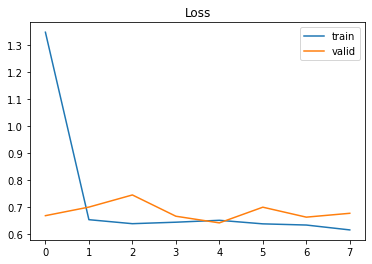

In [14]:
import matplotlib.pyplot as plt

epochs = np.arange(config.n_epoch)

plt.title('Loss') 
plt.plot(epochs, total_train_loss, label="train") 
plt.plot(epochs, total_valid_loss, label="valid") 
plt.legend()
plt.show()

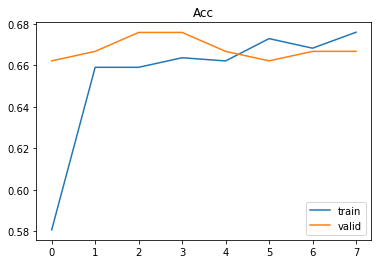

In [15]:
plt.title('Acc') 
plt.plot(epochs, total_train_acc, label="train") 
plt.plot(epochs, total_valid_acc, label="valid") 
plt.legend()
plt.show()